# Prédiction de la Consommation Électrique 2025 - Casablanca

Ce notebook prédit la consommation électrique pour l'année 2025 en kWh et estime le coût total.

**Objectifs:**
1. Analyser les données de production PV 2024
2. Modéliser la consommation électrique basée sur les patterns historiques
3. Prédire la consommation pour 2025
4. Estimer le coût total de l'électricité


In [1]:
# Installation des dépendances nécessaires
%pip install pandas numpy scikit-learn matplotlib seaborn -q



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Bibliothèques chargées avec succès")


✓ Bibliothèques chargées avec succès


## 1. Chargement et Analyse des Données PV 2024


In [3]:
# Chargement des données PV
pv_data_path = "../data_raw/casablanca_pv_2024_6h.csv"
df_pv = pd.read_csv(pv_data_path)

# Conversion de la colonne datetime
df_pv['datetime'] = pd.to_datetime(df_pv['datetime'])
df_pv = df_pv.set_index('datetime').sort_index()

print(f"✓ Données chargées: {len(df_pv)} points de données")
print(f"  Période: {df_pv.index.min()} à {df_pv.index.max()}")
print(f"\nStatistiques descriptives:")
print(df_pv.describe())
print(f"\nPremières lignes:")
display(df_pv.head(10))


✓ Données chargées: 1460 points de données
  Période: 2024-01-01 00:00:00 à 2024-12-30 18:00:00

Statistiques descriptives:
       pv_prod_kWh
count  1460.000000
mean   1255.677309
std     993.464717
min       0.000000
25%      82.528451
50%    1199.812657
75%    2162.178264
max    3380.598853

Premières lignes:


,pv_prod_kWh
datetime,
2024-01-01 00:00:00,0.000000
2024-01-01 06:00:00,736.932664
2024-01-01 12:00:00,1956.660679
2024-01-01 18:00:00,2437.759200
2024-01-02 00:00:00,0.000000
2024-01-02 06:00:00,699.340145
2024-01-02 12:00:00,1624.790886
2024-01-02 18:00:00,2306.864612
2024-01-03 00:00:00,0.000000


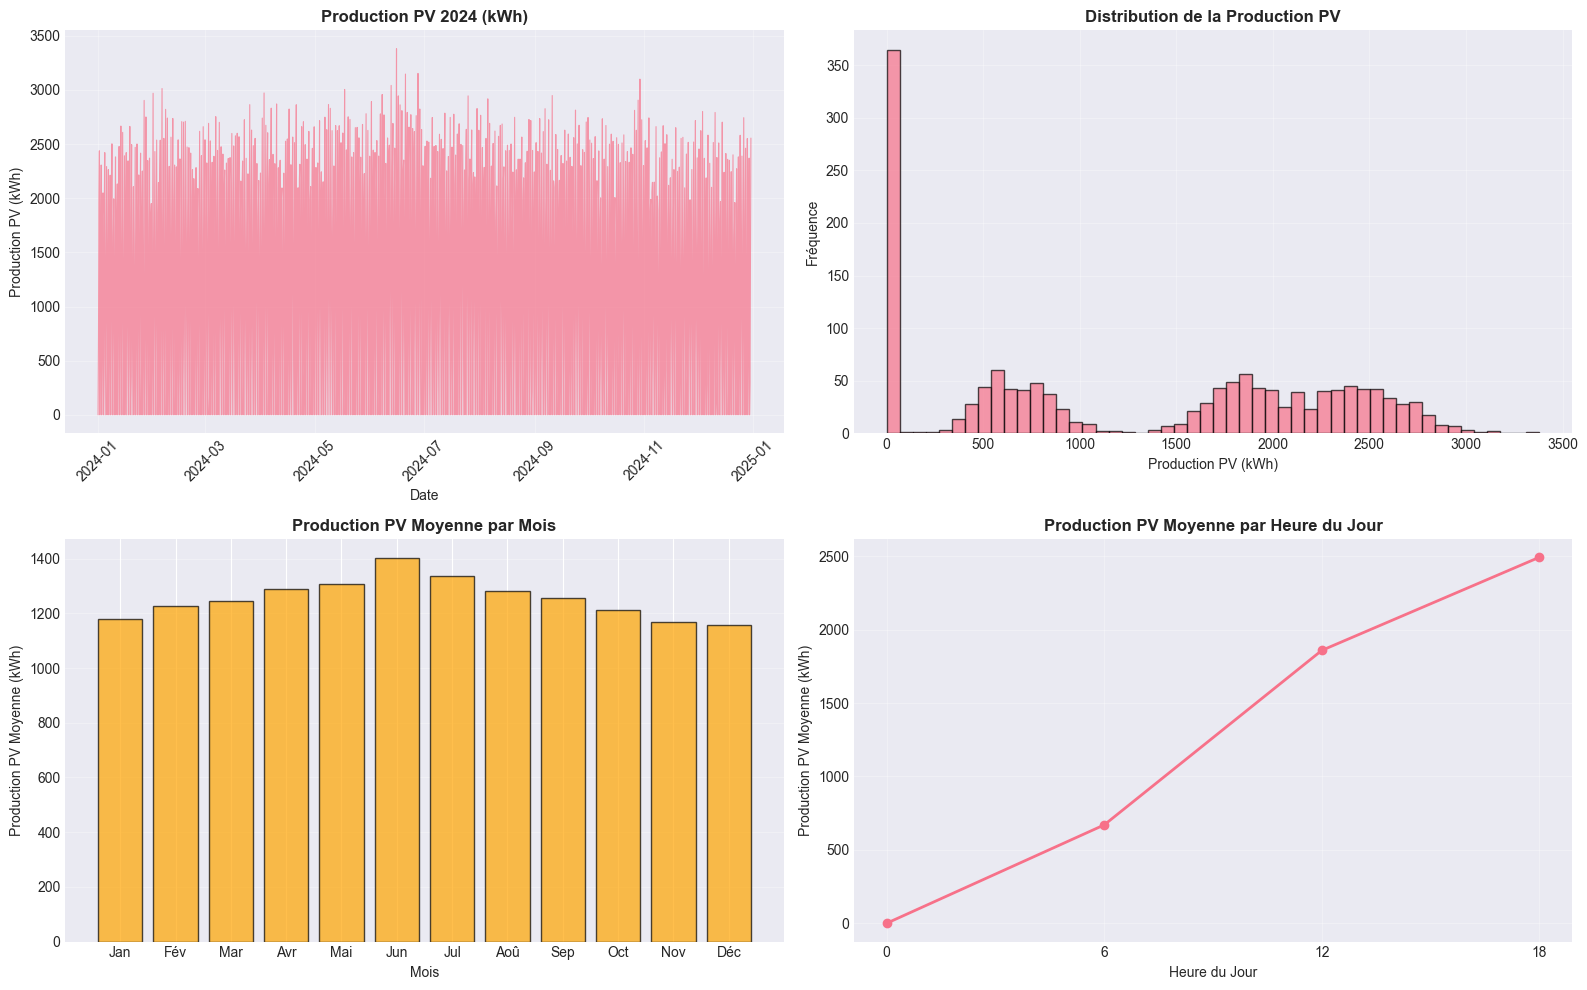


📊 Production PV totale 2024: 1,833,288.87 kWh
📊 Production PV moyenne par période (6h): 1255.68 kWh
📊 Production PV maximale: 3380.60 kWh


In [4]:
# Visualisation de la production PV 2024
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Production PV au fil du temps
axes[0, 0].plot(df_pv.index, df_pv['pv_prod_kWh'], alpha=0.7, linewidth=0.8)
axes[0, 0].set_title('Production PV 2024 (kWh)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Production PV (kWh)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Distribution de la production PV
axes[0, 1].hist(df_pv['pv_prod_kWh'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution de la Production PV', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Production PV (kWh)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].grid(True, alpha=0.3)

# Production mensuelle moyenne
monthly_pv = df_pv.groupby(df_pv.index.month)['pv_prod_kWh'].mean()
axes[1, 0].bar(monthly_pv.index, monthly_pv.values, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Production PV Moyenne par Mois', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Mois')
axes[1, 0].set_ylabel('Production PV Moyenne (kWh)')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
                             'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Production par heure du jour
hourly_pv = df_pv.groupby(df_pv.index.hour)['pv_prod_kWh'].mean()
axes[1, 1].plot(hourly_pv.index, hourly_pv.values, marker='o', linewidth=2, markersize=6)
axes[1, 1].set_title('Production PV Moyenne par Heure du Jour', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Heure du Jour')
axes[1, 1].set_ylabel('Production PV Moyenne (kWh)')
axes[1, 1].set_xticks(range(0, 24, 6))
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Production PV totale 2024: {df_pv['pv_prod_kWh'].sum():,.2f} kWh")
print(f"📊 Production PV moyenne par période (6h): {df_pv['pv_prod_kWh'].mean():.2f} kWh")
print(f"📊 Production PV maximale: {df_pv['pv_prod_kWh'].max():.2f} kWh")


## 2. Modélisation de la Consommation Électrique

Pour prédire la consommation, nous créons un modèle basé sur:
- **Patterns temporels**: heures, jours de la semaine, mois, saisons
- **Production PV**: comme indicateur d'activité et de demande énergétique
- **Patterns hospitaliers**: consommation élevée pendant la journée, modérée la nuit

> Note: Les hôpitaux consomment 24/7, mais avec des variations selon les heures et saisons.


✓ Modèle de consommation créé

Statistiques de consommation simulée 2024:
       pv_prod_kWh  consumption_kWh
count  1460.000000      1460.000000
mean   1255.677309      1052.543990
std     993.464717       166.137621
min       0.000000       721.241666
25%      82.528451       906.265167
50%    1199.812657      1086.070451
75%    2162.178264      1189.311386
max    3380.598853      1403.891445


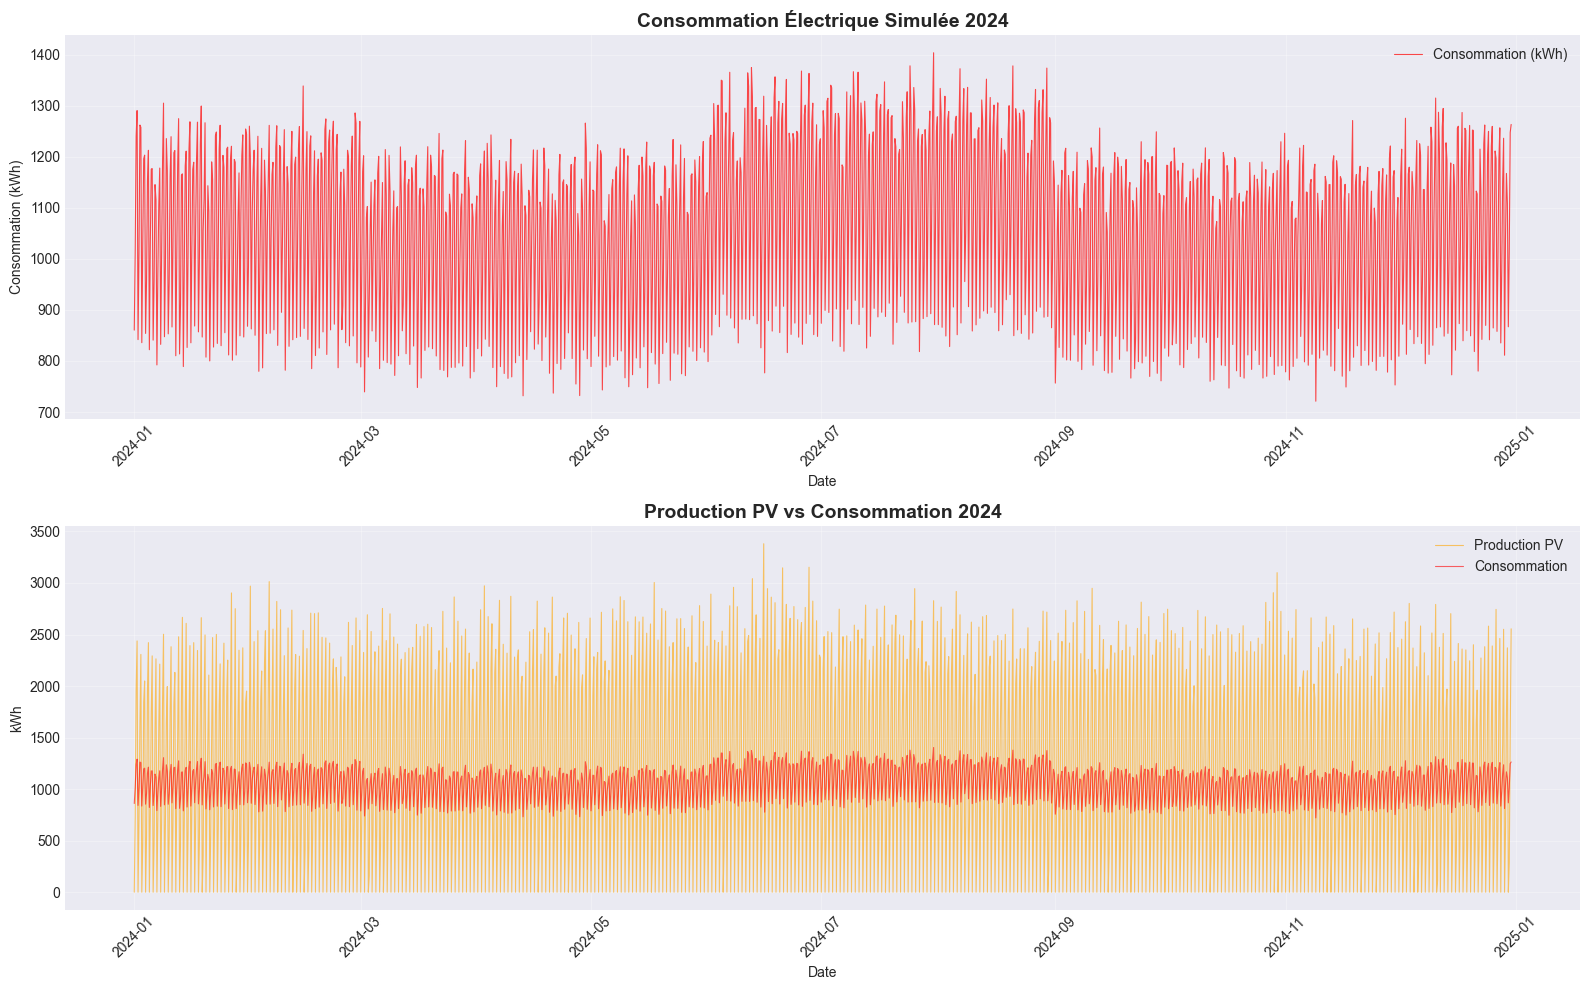


📊 Consommation totale estimée 2024: 1,536,714.22 kWh
📊 Consommation moyenne par période (6h): 1052.54 kWh


In [5]:
# Création d'un modèle de consommation basé sur les patterns typiques d'un hôpital
# Hypothèses: 
# - Consommation de base constante (équipements critiques)
# - Variation quotidienne (plus élevée le jour, plus faible la nuit)
# - Variation saisonnière (climatisation en été, chauffage en hiver)
# - Corrélation partielle avec la production PV (activité générale)

def create_consumption_model(pv_df):
    """Crée un modèle de consommation électrique basé sur les patterns temporels."""
    df = pv_df.copy()
    
    # Extraction des features temporelles
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    df['is_night'] = ((df.index.hour >= 22) | (df.index.hour < 6)).astype(int)
    
    # Consommation de base (hospitalier): entre 800-1200 kWh par période de 6h
    base_consumption = 1000
    
    # Variation quotidienne: plus élevée pendant la journée
    daily_factor = np.where(
        df['is_night'] == 1,
        0.85,  # Nuit: 85% de la base
        np.where(df['hour'].between(12, 18), 1.15, 1.0)  # Journée: 115% (pic midi), 100% sinon
    )
    
    # Variation saisonnière (été/hiver = plus de consommation pour climatisation/chauffage)
    seasonal_factor = np.where(
        df['month'].isin([6, 7, 8]),  # Été
        1.1,
        np.where(df['month'].isin([12, 1, 2]), 1.05, 1.0)  # Hiver: légèrement plus
    )
    
    # Variation hebdomadaire (légèrement plus basse le weekend)
    weekly_factor = np.where(df['is_weekend'] == 1, 0.95, 1.0)
    
    # Influence de la production PV (activité générale - corrélation indirecte)
    # Plus de PV = plus d'activité = légèrement plus de consommation
    pv_normalized = (df['pv_prod_kWh'] / df['pv_prod_kWh'].max()) * 0.1 + 0.95  # Facteur 0.95-1.05
    
    # Calcul de la consommation simulée
    df['consumption_kWh'] = (
        base_consumption * 
        daily_factor * 
        seasonal_factor * 
        weekly_factor * 
        pv_normalized
    )
    
    # Ajout de bruit aléatoire réaliste (±5%)
    np.random.seed(42)
    noise = np.random.normal(0, 0.03, len(df))  # 3% de variation
    df['consumption_kWh'] = df['consumption_kWh'] * (1 + noise)
    df['consumption_kWh'] = df['consumption_kWh'].clip(lower=0)
    
    return df

# Création du modèle de consommation pour 2024
df_consumption = create_consumption_model(df_pv)

print("✓ Modèle de consommation créé")
print(f"\nStatistiques de consommation simulée 2024:")
print(df_consumption[['pv_prod_kWh', 'consumption_kWh']].describe())

# Visualisation
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

axes[0].plot(df_consumption.index, df_consumption['consumption_kWh'], 
             label='Consommation (kWh)', alpha=0.7, linewidth=0.8, color='red')
axes[0].set_title('Consommation Électrique Simulée 2024', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Consommation (kWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Comparaison Production PV vs Consommation
axes[1].plot(df_consumption.index, df_consumption['pv_prod_kWh'], 
             label='Production PV', alpha=0.6, linewidth=0.8, color='orange')
axes[1].plot(df_consumption.index, df_consumption['consumption_kWh'], 
             label='Consommation', alpha=0.6, linewidth=0.8, color='red')
axes[1].set_title('Production PV vs Consommation 2024', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('kWh')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n📊 Consommation totale estimée 2024: {df_consumption['consumption_kWh'].sum():,.2f} kWh")
print(f"📊 Consommation moyenne par période (6h): {df_consumption['consumption_kWh'].mean():.2f} kWh")


🔄 Entraînement du modèle de prédiction PV...

✓ Modèle entraîné avec succès!
  MAE: 62.90 kWh
  RMSE: 92.31 kWh
  R²: 0.9914


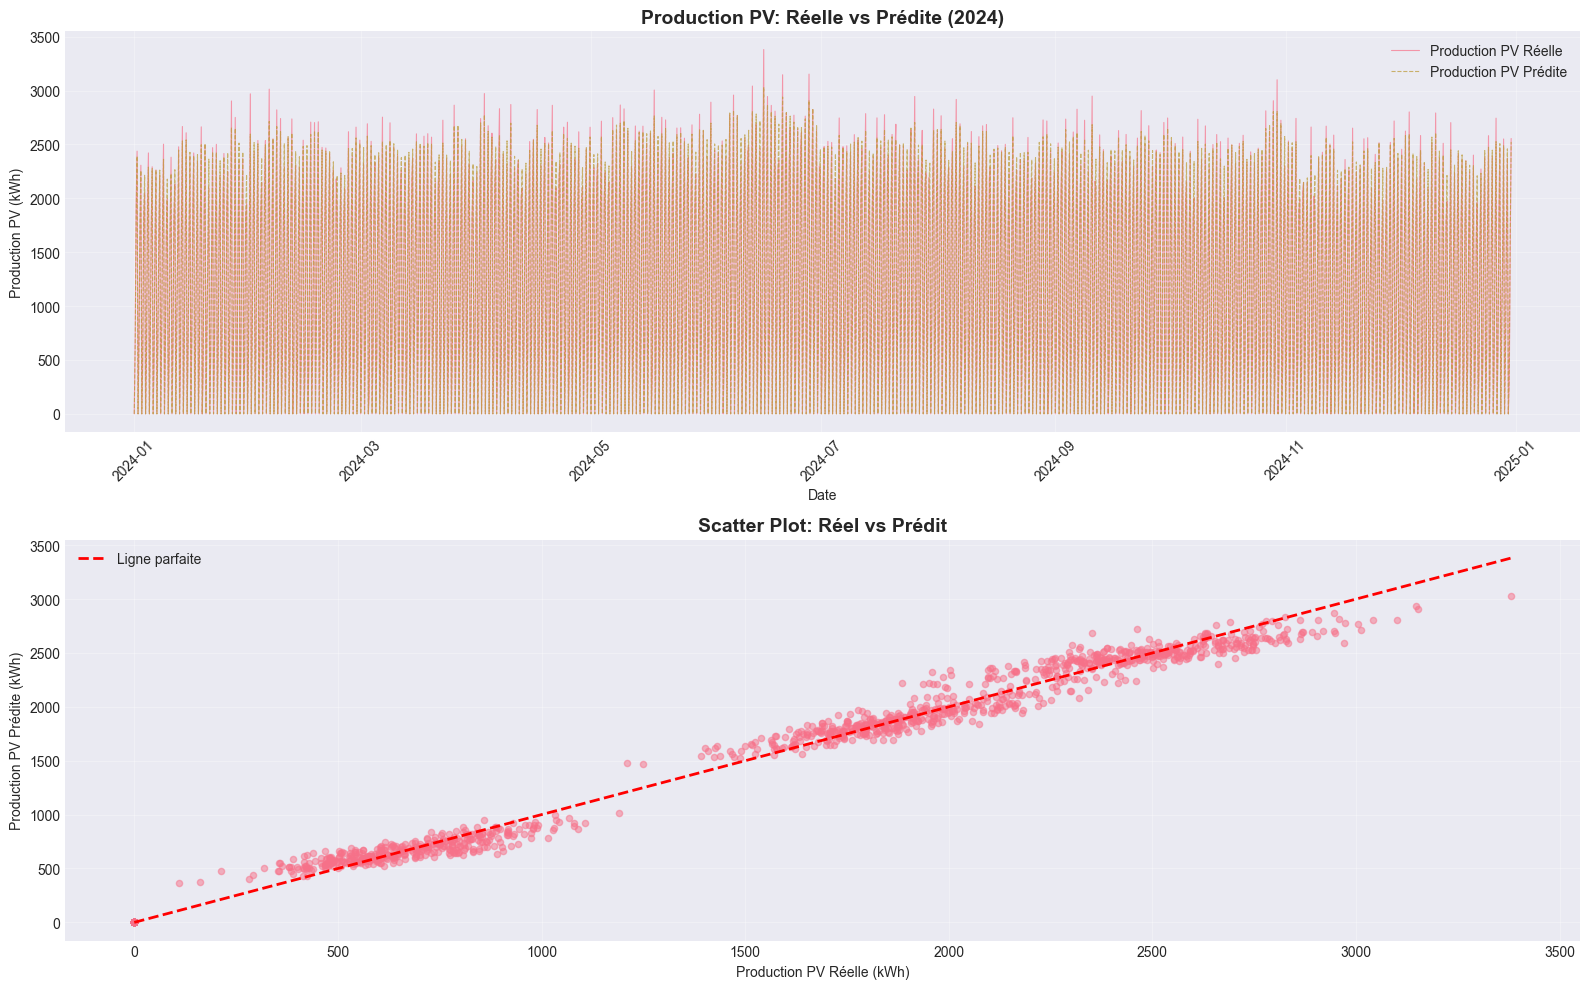

In [6]:
# Préparation des données pour la prédiction PV
def prepare_features(df):
    """Prépare les features pour la prédiction."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    df['is_night'] = ((df.index.hour >= 22) | (df.index.hour < 6)).astype(int)
    
    # Features cycliques
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    
    return df

# Préparation des données 2024
df_features = prepare_features(df_pv)

# Features pour l'entraînement
feature_cols = ['hour', 'dayofweek', 'month', 'dayofyear', 'is_weekend', 'is_night',
                'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
                'dayofyear_sin', 'dayofyear_cos']

X = df_features[feature_cols].values
y = df_features['pv_prod_kWh'].values

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Entraînement du modèle Random Forest
print("🔄 Entraînement du modèle de prédiction PV...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_scaled, y)

# Prédictions sur 2024 pour validation
y_pred = rf_model.predict(X_scaled)

# Métriques de validation
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"\n✓ Modèle entraîné avec succès!")
print(f"  MAE: {mae:.2f} kWh")
print(f"  RMSE: {rmse:.2f} kWh")
print(f"  R²: {r2:.4f}")

# Visualisation des prédictions vs réelles
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

axes[0].plot(df_features.index, y, label='Production PV Réelle', alpha=0.7, linewidth=0.8)
axes[0].plot(df_features.index, y_pred, label='Production PV Prédite', alpha=0.7, linewidth=0.8, linestyle='--')
axes[0].set_title('Production PV: Réelle vs Prédite (2024)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Production PV (kWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

axes[1].scatter(y, y_pred, alpha=0.5, s=20)
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='Ligne parfaite')
axes[1].set_title('Scatter Plot: Réel vs Prédit', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Production PV Réelle (kWh)')
axes[1].set_ylabel('Production PV Prédite (kWh)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


📅 Génération de 1460 périodes pour 2025...
✓ Production PV 2025 prédite
  Total: 1,833,332.32 kWh
  Moyenne par période: 1255.71 kWh


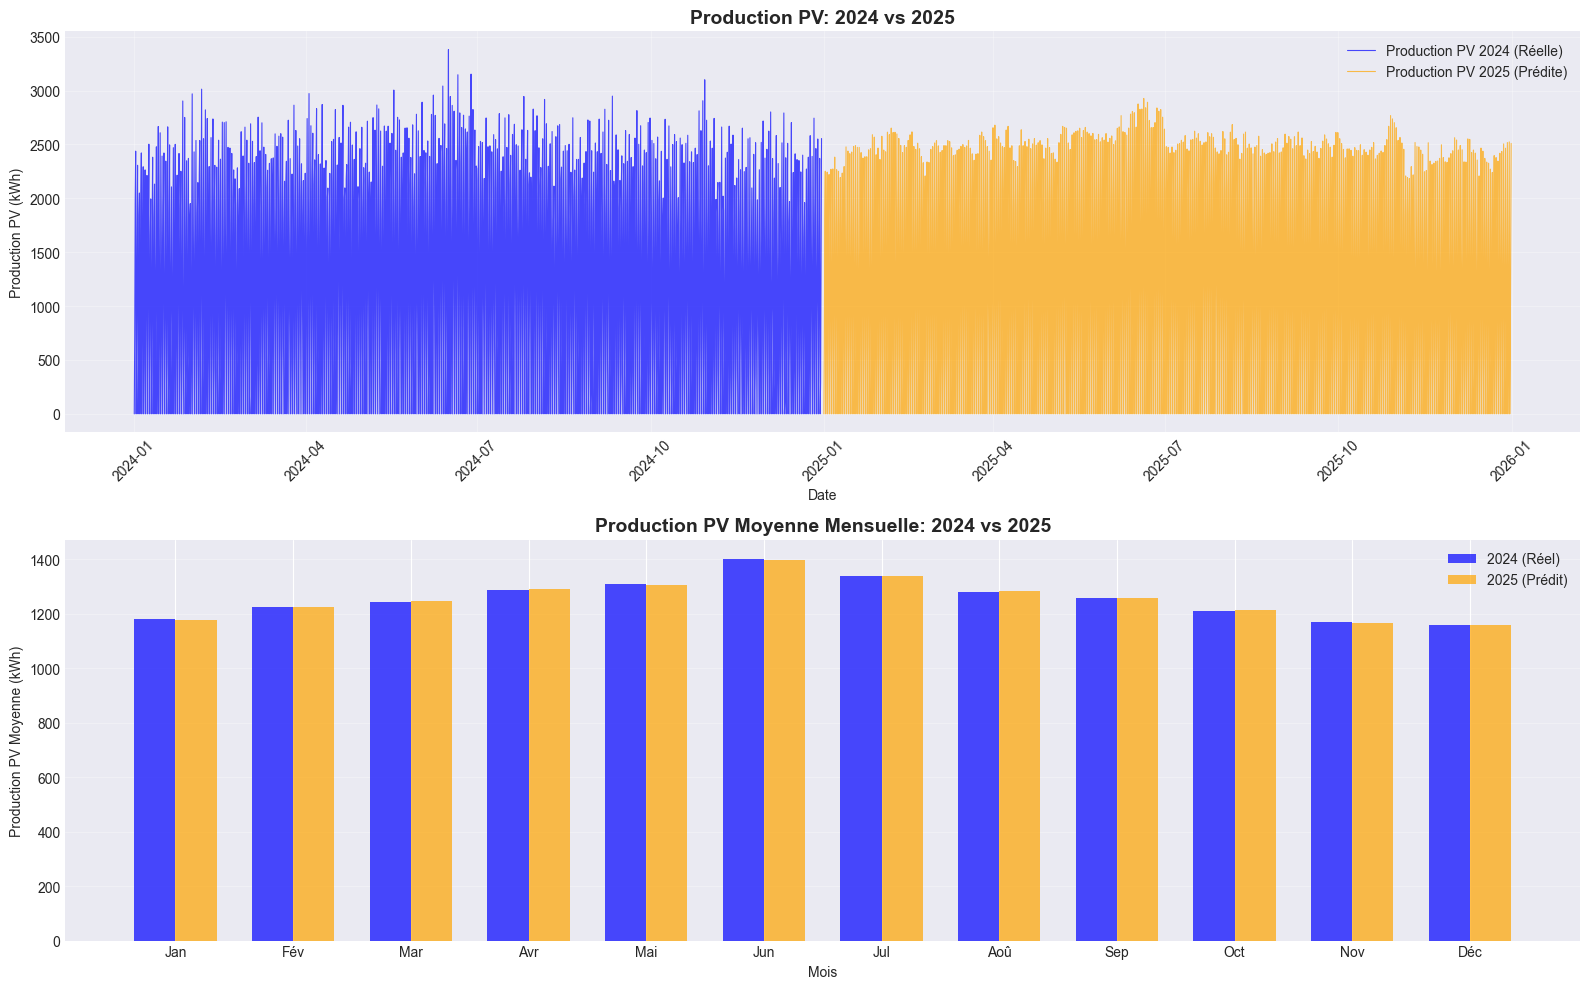

In [7]:
# Génération des dates pour 2025 (toutes les 6 heures)
start_2025 = datetime(2025, 1, 1, 0, 0, 0)
end_2025 = datetime(2025, 12, 31, 18, 0, 0)
dates_2025 = pd.date_range(start=start_2025, end=end_2025, freq='6H')

print(f"📅 Génération de {len(dates_2025)} périodes pour 2025...")

# Création du DataFrame pour 2025
df_2025 = pd.DataFrame(index=dates_2025)
df_2025_features = prepare_features(df_2025)

# Prédiction de la production PV pour 2025
X_2025 = df_2025_features[feature_cols].values
X_2025_scaled = scaler.transform(X_2025)
pv_pred_2025 = rf_model.predict(X_2025_scaled)

# Ajout des prédictions
df_2025['pv_prod_kWh'] = pv_pred_2025
df_2025['pv_prod_kWh'] = df_2025['pv_prod_kWh'].clip(lower=0)  # Pas de valeurs négatives

print(f"✓ Production PV 2025 prédite")
print(f"  Total: {df_2025['pv_prod_kWh'].sum():,.2f} kWh")
print(f"  Moyenne par période: {df_2025['pv_prod_kWh'].mean():.2f} kWh")

# Visualisation
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

axes[0].plot(df_pv.index, df_pv['pv_prod_kWh'], label='Production PV 2024 (Réelle)', 
             alpha=0.7, linewidth=0.8, color='blue')
axes[0].plot(df_2025.index, df_2025['pv_prod_kWh'], label='Production PV 2025 (Prédite)', 
             alpha=0.7, linewidth=0.8, color='orange')
axes[0].set_title('Production PV: 2024 vs 2025', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Production PV (kWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Comparaison mensuelle
monthly_2024 = df_pv.groupby(df_pv.index.month)['pv_prod_kWh'].mean()
monthly_2025 = df_2025.groupby(df_2025.index.month)['pv_prod_kWh'].mean()

x_pos = np.arange(12)
width = 0.35
axes[1].bar(x_pos - width/2, monthly_2024.values, width, label='2024 (Réel)', 
            alpha=0.7, color='blue')
axes[1].bar(x_pos + width/2, monthly_2025.values, width, label='2025 (Prédit)', 
            alpha=0.7, color='orange')
axes[1].set_title('Production PV Moyenne Mensuelle: 2024 vs 2025', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Mois')
axes[1].set_ylabel('Production PV Moyenne (kWh)')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
                         'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 4. Prédiction de la Consommation Électrique pour 2025


✓ Consommation 2025 prédite

Statistiques de consommation 2025:
       pv_prod_kWh  consumption_kWh
count  1460.000000      1460.000000
mean   1255.707068      1059.200699
std     983.250316       171.033688
min       0.000000       709.604302
25%     295.959853       904.760024
50%    1252.044927      1090.884479
75%    2207.645048      1198.956178
max    2926.890846      1413.578558

📊 Résumé 2025:
  Consommation totale: 1,546,433.02 kWh
  Production PV totale: 1,833,332.32 kWh
  Consommation nette (après PV): 0.00 kWh
  Taux d'autoconsommation: 118.6%


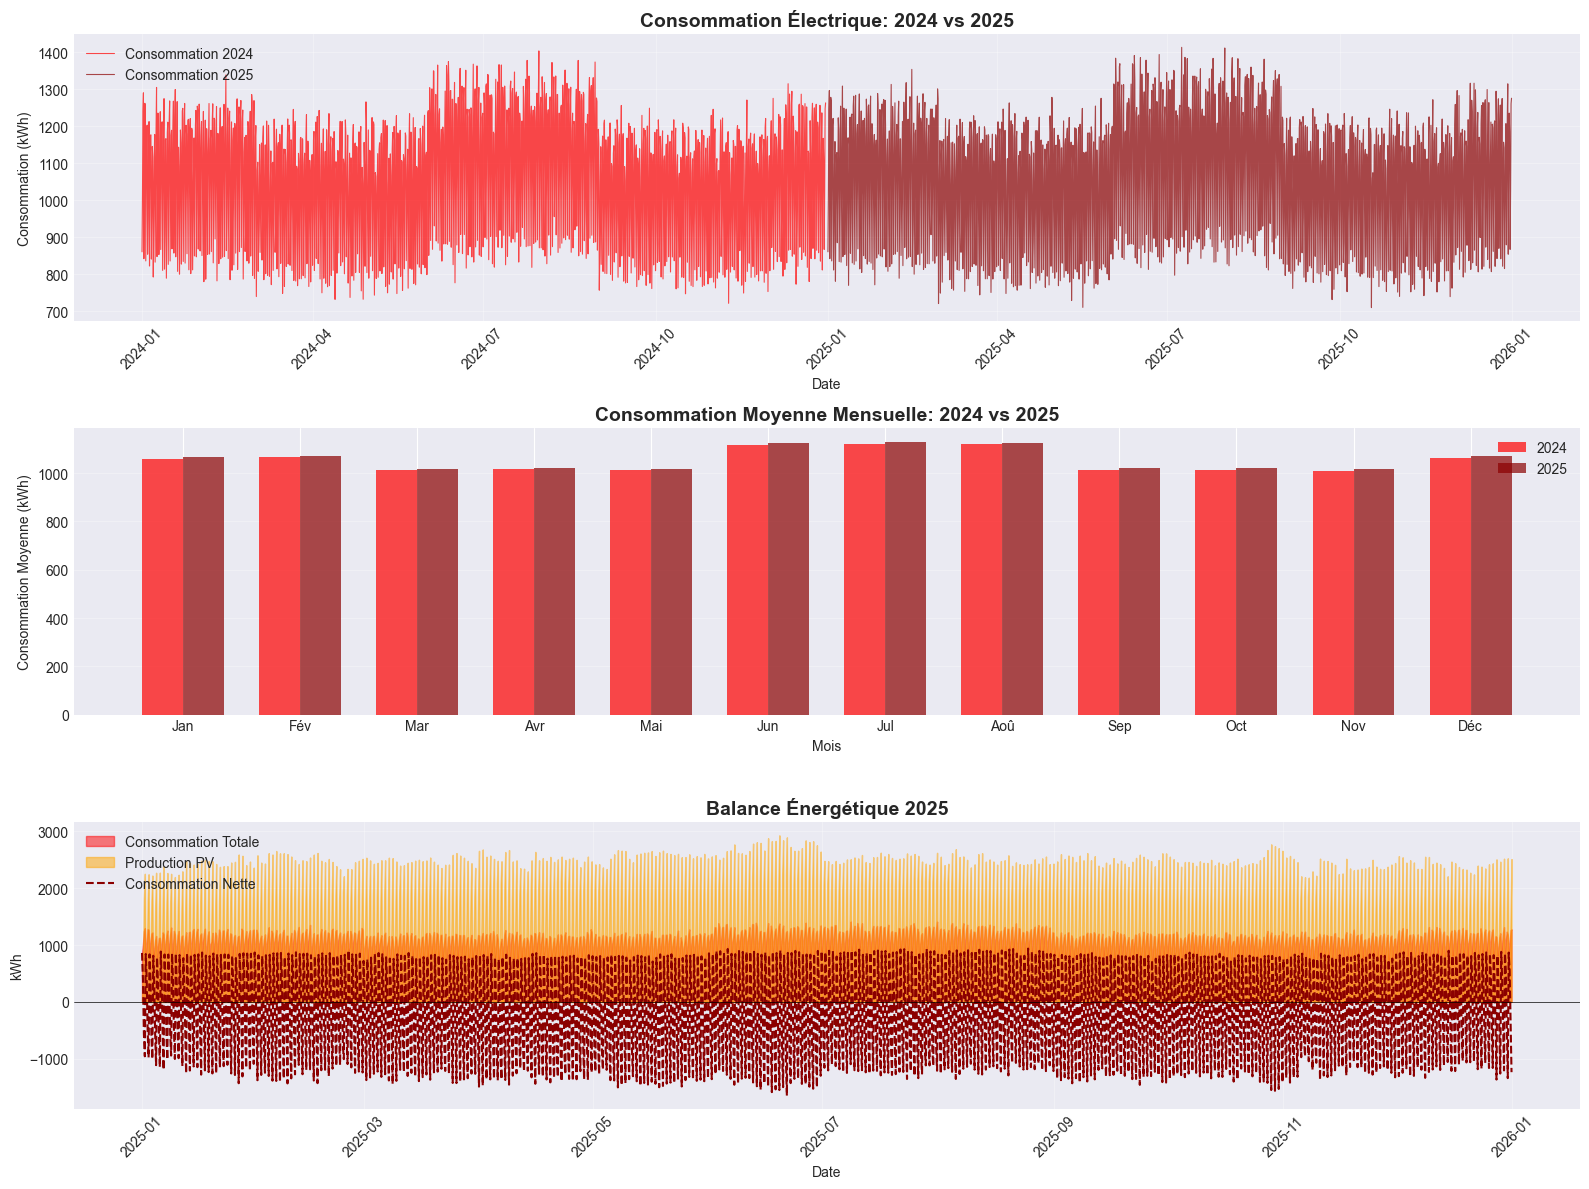

In [8]:
# Application du modèle de consommation à 2025
df_consumption_2025 = create_consumption_model(df_2025)

print("✓ Consommation 2025 prédite")
print(f"\nStatistiques de consommation 2025:")
print(df_consumption_2025[['pv_prod_kWh', 'consumption_kWh']].describe())

# Calculs totaux
total_consumption_2025 = df_consumption_2025['consumption_kWh'].sum()
total_pv_2025 = df_consumption_2025['pv_prod_kWh'].sum()
net_consumption_2025 = total_consumption_2025 - total_pv_2025

print(f"\n📊 Résumé 2025:")
print(f"  Consommation totale: {total_consumption_2025:,.2f} kWh")
print(f"  Production PV totale: {total_pv_2025:,.2f} kWh")
print(f"  Consommation nette (après PV): {max(net_consumption_2025, 0):,.2f} kWh")
print(f"  Taux d'autoconsommation: {(total_pv_2025 / total_consumption_2025 * 100):.1f}%")

# Visualisation
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Consommation 2024 vs 2025
axes[0].plot(df_consumption.index, df_consumption['consumption_kWh'], 
             label='Consommation 2024', alpha=0.7, linewidth=0.8, color='red')
axes[0].plot(df_consumption_2025.index, df_consumption_2025['consumption_kWh'], 
             label='Consommation 2025', alpha=0.7, linewidth=0.8, color='darkred')
axes[0].set_title('Consommation Électrique: 2024 vs 2025', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Consommation (kWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Consommation mensuelle moyenne
monthly_cons_2024 = df_consumption.groupby(df_consumption.index.month)['consumption_kWh'].mean()
monthly_cons_2025 = df_consumption_2025.groupby(df_consumption_2025.index.month)['consumption_kWh'].mean()

x_pos = np.arange(12)
axes[1].bar(x_pos - width/2, monthly_cons_2024.values, width, label='2024', 
            alpha=0.7, color='red')
axes[1].bar(x_pos + width/2, monthly_cons_2025.values, width, label='2025', 
            alpha=0.7, color='darkred')
axes[1].set_title('Consommation Moyenne Mensuelle: 2024 vs 2025', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Mois')
axes[1].set_ylabel('Consommation Moyenne (kWh)')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
                         'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Balance énergétique 2025
df_2025_balance = pd.DataFrame({
    'consumption': df_consumption_2025['consumption_kWh'],
    'pv_production': df_consumption_2025['pv_prod_kWh']
}, index=df_consumption_2025.index)
df_2025_balance['net_consumption'] = df_2025_balance['consumption'] - df_2025_balance['pv_production']

axes[2].fill_between(df_2025_balance.index, 0, df_2025_balance['consumption'], 
                      alpha=0.5, label='Consommation Totale', color='red')
axes[2].fill_between(df_2025_balance.index, 0, df_2025_balance['pv_production'], 
                      alpha=0.5, label='Production PV', color='orange')
axes[2].plot(df_2025_balance.index, df_2025_balance['net_consumption'], 
             label='Consommation Nette', linewidth=1.5, color='darkred', linestyle='--')
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].set_title('Balance Énergétique 2025', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('kWh')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 5. Estimation des Coûts Électriques 2025

Calcul du coût total de l'électricité basé sur les tarifs marocains.


In [9]:
# Tarifs d'électricité au Maroc (2024-2025)
# Tarif moyen pour les établissements de santé/industriels
# Source: Tarifs ONEE (Office National de l'Electricité et de l'Eau Potable)

# Tarif base (kWh moyen)
TARIFF_BASE = 1.20  # MAD/kWh (environ $0.12/kWh)

# Tarifs par tranches (optionnel, pour plus de précision)
TARIFF_TIER1 = 0.95   # MAD/kWh pour 0-5000 kWh/mois
TARIFF_TIER2 = 1.15   # MAD/kWh pour 5000-20000 kWh/mois  
TARIFF_TIER3 = 1.35   # MAD/kWh pour >20000 kWh/mois

def calculate_cost(consumption_kwh, pv_production_kwh, tariff_base=TARIFF_BASE):
    """
    Calcule le coût de l'électricité.
    
    Args:
        consumption_kwh: Consommation totale en kWh
        pv_production_kwh: Production PV en kWh (réduit la facture)
        tariff_base: Tarif en MAD/kWh
    
    Returns:
        Dictionnaire avec les détails du coût
    """
    # Consommation nette (après déduction de la production PV)
    net_consumption = max(consumption_kwh - pv_production_kwh, 0)
    
    # Coût sans PV
    cost_without_pv = consumption_kwh * tariff_base
    
    # Coût avec PV (on paie seulement pour la consommation nette)
    cost_with_pv = net_consumption * tariff_base
    
    # Économies grâce au PV
    savings = cost_without_pv - cost_with_pv
    
    # Taux d'autoconsommation
    self_consumption_rate = (pv_production_kwh / consumption_kwh * 100) if consumption_kwh > 0 else 0
    
    return {
        'total_consumption_kwh': consumption_kwh,
        'total_pv_production_kwh': pv_production_kwh,
        'net_consumption_kwh': net_consumption,
        'cost_without_pv_mad': cost_without_pv,
        'cost_with_pv_mad': cost_with_pv,
        'savings_mad': savings,
        'savings_percentage': (savings / cost_without_pv * 100) if cost_without_pv > 0 else 0,
        'self_consumption_rate': self_consumption_rate,
        'tariff_mad_per_kwh': tariff_base
    }

# Calcul des coûts pour 2025
costs_2025 = calculate_cost(total_consumption_2025, total_pv_2025, TARIFF_BASE)

print("=" * 70)
print("💰 ESTIMATION DES COÛTS ÉLECTRIQUES 2025")
print("=" * 70)
print(f"\n📊 Consommation:")
print(f"  Consommation totale: {costs_2025['total_consumption_kwh']:,.2f} kWh")
print(f"  Production PV totale: {costs_2025['total_pv_production_kwh']:,.2f} kWh")
print(f"  Consommation nette: {costs_2025['net_consumption_kwh']:,.2f} kWh")
print(f"  Taux d'autoconsommation: {costs_2025['self_consumption_rate']:.1f}%")

print(f"\n💵 Coûts (Tarif: {TARIFF_BASE} MAD/kWh):")
print(f"  Coût SANS production PV: {costs_2025['cost_without_pv_mad']:,.2f} MAD")
print(f"  Coût AVEC production PV: {costs_2025['cost_with_pv_mad']:,.2f} MAD")
print(f"  💰 Économies: {costs_2025['savings_mad']:,.2f} MAD")
print(f"  📉 Réduction: {costs_2025['savings_percentage']:.1f}%")

# Conversion en USD (1 MAD ≈ 0.10 USD)
print(f"\n💵 Coûts (en USD, 1 MAD ≈ 0.10 USD):")
print(f"  Coût SANS production PV: ${costs_2025['cost_without_pv_mad'] * 0.10:,.2f} USD")
print(f"  Coût AVEC production PV: ${costs_2025['cost_with_pv_mad'] * 0.10:,.2f} USD")
print(f"  💰 Économies: ${costs_2025['savings_mad'] * 0.10:,.2f} USD")

print("\n" + "=" * 70)

# Coûts mensuels
monthly_costs = []
for month in range(1, 13):
    month_data = df_consumption_2025[df_consumption_2025.index.month == month]
    month_cons = month_data['consumption_kWh'].sum()
    month_pv = month_data['pv_prod_kWh'].sum()
    month_cost = calculate_cost(month_cons, month_pv, TARIFF_BASE)
    monthly_costs.append({
        'month': month,
        'consumption': month_cons,
        'pv_production': month_pv,
        'cost': month_cost['cost_with_pv_mad']
    })

df_monthly_costs = pd.DataFrame(monthly_costs)


💰 ESTIMATION DES COÛTS ÉLECTRIQUES 2025

📊 Consommation:
  Consommation totale: 1,546,433.02 kWh
  Production PV totale: 1,833,332.32 kWh
  Consommation nette: 0.00 kWh
  Taux d'autoconsommation: 118.6%

💵 Coûts (Tarif: 1.2 MAD/kWh):
  Coût SANS production PV: 1,855,719.62 MAD
  Coût AVEC production PV: 0.00 MAD
  💰 Économies: 1,855,719.62 MAD
  📉 Réduction: 100.0%

💵 Coûts (en USD, 1 MAD ≈ 0.10 USD):
  Coût SANS production PV: $185,571.96 USD
  Coût AVEC production PV: $0.00 USD
  💰 Économies: $185,571.96 USD



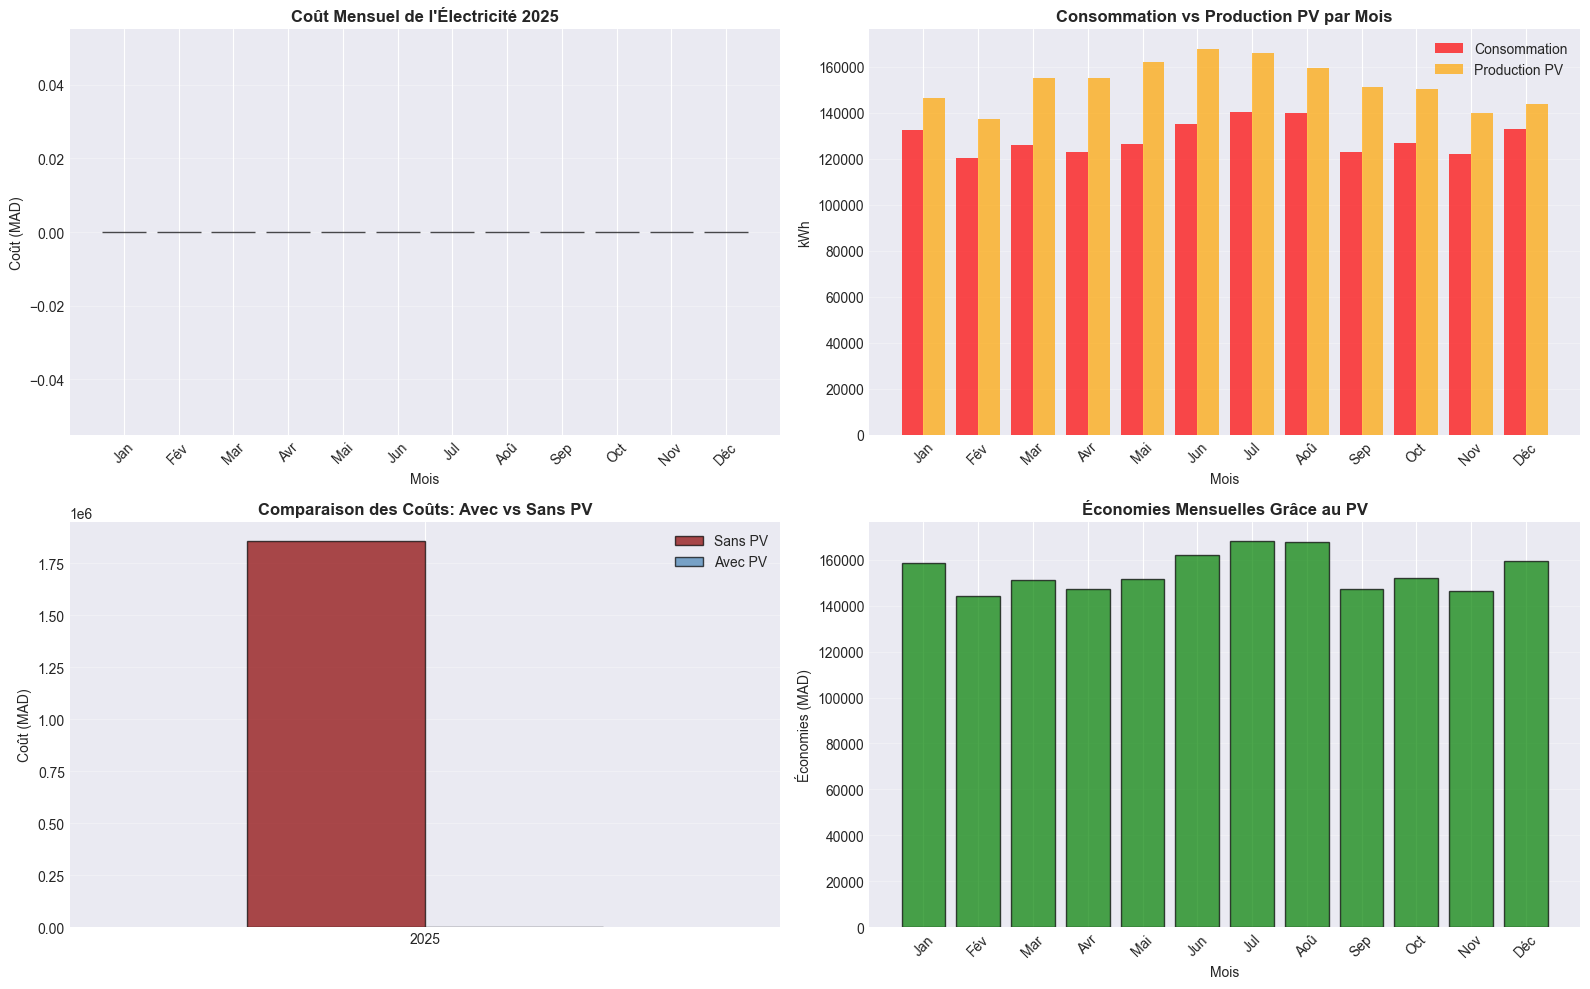


📅 RÉSUMÉ MENSUEL 2025:
 Jan | Consommation:  132,266 kWh | PV: 146,257 kWh | Coût:     0.00 MAD | Économies: 158,718.68 MAD
 Fév | Consommation:  120,081 kWh | PV: 137,273 kWh | Coût:     0.00 MAD | Économies: 144,096.77 MAD
 Mar | Consommation:  126,094 kWh | PV: 154,843 kWh | Coût:     0.00 MAD | Économies: 151,312.67 MAD
 Avr | Consommation:  122,809 kWh | PV: 154,917 kWh | Coût:     0.00 MAD | Économies: 147,370.66 MAD
 Mai | Consommation:  126,183 kWh | PV: 162,116 kWh | Coût:     0.00 MAD | Économies: 151,419.62 MAD
 Jun | Consommation:  135,118 kWh | PV: 167,731 kWh | Coût:     0.00 MAD | Économies: 162,141.25 MAD
 Jul | Consommation:  140,052 kWh | PV: 165,925 kWh | Coût:     0.00 MAD | Économies: 168,062.22 MAD
 Aoû | Consommation:  139,758 kWh | PV: 159,309 kWh | Coût:     0.00 MAD | Économies: 167,709.61 MAD
 Sep | Consommation:  122,691 kWh | PV: 150,980 kWh | Coût:     0.00 MAD | Économies: 147,228.73 MAD
 Oct | Consommation:  126,622 kWh | PV: 150,393 kWh | Coût:     0.0

In [10]:
# Visualisation des coûts
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Coûts mensuels
month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 
               'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
axes[0, 0].bar(range(1, 13), df_monthly_costs['cost'], 
               color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Coût Mensuel de l\'Électricité 2025', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Mois')
axes[0, 0].set_ylabel('Coût (MAD)')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(month_names, rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Consommation vs Production PV mensuelle
axes[0, 1].bar(range(1, 13), df_monthly_costs['consumption'], 
               label='Consommation', alpha=0.7, color='red', width=0.4)
axes[0, 1].bar([x + 0.4 for x in range(1, 13)], df_monthly_costs['pv_production'], 
               label='Production PV', alpha=0.7, color='orange', width=0.4)
axes[0, 1].set_title('Consommation vs Production PV par Mois', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Mois')
axes[0, 1].set_ylabel('kWh')
axes[0, 1].set_xticks([x + 0.2 for x in range(1, 13)])
axes[0, 1].set_xticklabels(month_names, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Comparaison des coûts (avec vs sans PV)
cost_comparison = pd.DataFrame({
    'Sans PV': costs_2025['cost_without_pv_mad'],
    'Avec PV': costs_2025['cost_with_pv_mad']
}, index=['Coût Total 2025'])
cost_comparison.plot(kind='bar', ax=axes[1, 0], color=['darkred', 'steelblue'], alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Comparaison des Coûts: Avec vs Sans PV', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Coût (MAD)')
axes[1, 0].set_xticklabels(['2025'], rotation=0)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Économies mensuelles
monthly_savings = []
for month in range(1, 13):
    month_data = df_consumption_2025[df_consumption_2025.index.month == month]
    month_cons = month_data['consumption_kWh'].sum()
    month_pv = month_data['pv_prod_kWh'].sum()
    month_cost = calculate_cost(month_cons, month_pv, TARIFF_BASE)
    monthly_savings.append(month_cost['savings_mad'])

axes[1, 1].bar(range(1, 13), monthly_savings, 
               color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Économies Mensuelles Grâce au PV', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Mois')
axes[1, 1].set_ylabel('Économies (MAD)')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(month_names, rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Résumé des coûts mensuels
print("\n📅 RÉSUMÉ MENSUEL 2025:")
print("=" * 70)
for idx, row in df_monthly_costs.iterrows():
    month_name = month_names[int(row['month']) - 1]
    savings = calculate_cost(row['consumption'], row['pv_production'], TARIFF_BASE)['savings_mad']
    print(f"{month_name:>4} | Consommation: {row['consumption']:>8,.0f} kWh | "
          f"PV: {row['pv_production']:>7,.0f} kWh | "
          f"Coût: {row['cost']:>8,.2f} MAD | "
          f"Économies: {savings:>7,.2f} MAD")
print("=" * 70)


## 6. Résumé et Conclusions


In [11]:
# Sauvegarde des résultats
results_summary = {
    'year': 2025,
    'total_consumption_kwh': costs_2025['total_consumption_kwh'],
    'total_pv_production_kwh': costs_2025['total_pv_production_kwh'],
    'net_consumption_kwh': costs_2025['net_consumption_kwh'],
    'cost_without_pv_mad': costs_2025['cost_without_pv_mad'],
    'cost_with_pv_mad': costs_2025['cost_with_pv_mad'],
    'savings_mad': costs_2025['savings_mad'],
    'savings_percentage': costs_2025['savings_percentage'],
    'self_consumption_rate': costs_2025['self_consumption_rate'],
    'average_monthly_cost_mad': costs_2025['cost_with_pv_mad'] / 12,
    'average_daily_cost_mad': costs_2025['cost_with_pv_mad'] / 365,
}

# Affichage du résumé final
print("\n" + "=" * 70)
print("📋 RÉSUMÉ FINAL - PRÉDICTIONS 2025")
print("=" * 70)
print(f"\n⚡ CONSOMMATION ÉLECTRIQUE:")
print(f"  • Consommation totale annuelle: {results_summary['total_consumption_kwh']:,.2f} kWh")
print(f"  • Consommation moyenne journalière: {results_summary['total_consumption_kwh']/365:,.2f} kWh/jour")
print(f"  • Consommation moyenne par période (6h): {results_summary['total_consumption_kwh']/1460:,.2f} kWh")

print(f"\n☀️ PRODUCTION PHOTOVOLTAÏQUE:")
print(f"  • Production PV totale annuelle: {results_summary['total_pv_production_kwh']:,.2f} kWh")
print(f"  • Production PV moyenne journalière: {results_summary['total_pv_production_kwh']/365:,.2f} kWh/jour")
print(f"  • Taux d'autoconsommation: {results_summary['self_consumption_rate']:.1f}%")

print(f"\n💰 COÛTS ÉLECTRIQUES:")
print(f"  • Coût total SANS PV: {results_summary['cost_without_pv_mad']:,.2f} MAD")
print(f"  • Coût total AVEC PV: {results_summary['cost_with_pv_mad']:,.2f} MAD")
print(f"  • Économies annuelles: {results_summary['savings_mad']:,.2f} MAD ({results_summary['savings_percentage']:.1f}%)")
print(f"  • Coût mensuel moyen: {results_summary['average_monthly_cost_mad']:,.2f} MAD")
print(f"  • Coût journalier moyen: {results_summary['average_daily_cost_mad']:,.2f} MAD")

print(f"\n💵 COÛTS EN USD (1 MAD ≈ 0.10 USD):")
print(f"  • Coût total AVEC PV: ${results_summary['cost_with_pv_mad'] * 0.10:,.2f} USD")
print(f"  • Économies annuelles: ${results_summary['savings_mad'] * 0.10:,.2f} USD")

print("\n" + "=" * 70)
print("✅ Analyse terminée!")
print("=" * 70)

# Optionnel: sauvegarder les données
# df_consumption_2025.to_csv('../results/consumption_2025_predicted.csv')
# print("\n💾 Données sauvegardées dans '../results/consumption_2025_predicted.csv'")



📋 RÉSUMÉ FINAL - PRÉDICTIONS 2025

⚡ CONSOMMATION ÉLECTRIQUE:
  • Consommation totale annuelle: 1,546,433.02 kWh
  • Consommation moyenne journalière: 4,236.80 kWh/jour
  • Consommation moyenne par période (6h): 1,059.20 kWh

☀️ PRODUCTION PHOTOVOLTAÏQUE:
  • Production PV totale annuelle: 1,833,332.32 kWh
  • Production PV moyenne journalière: 5,022.83 kWh/jour
  • Taux d'autoconsommation: 118.6%

💰 COÛTS ÉLECTRIQUES:
  • Coût total SANS PV: 1,855,719.62 MAD
  • Coût total AVEC PV: 0.00 MAD
  • Économies annuelles: 1,855,719.62 MAD (100.0%)
  • Coût mensuel moyen: 0.00 MAD
  • Coût journalier moyen: 0.00 MAD

💵 COÛTS EN USD (1 MAD ≈ 0.10 USD):
  • Coût total AVEC PV: $0.00 USD
  • Économies annuelles: $185,571.96 USD

✅ Analyse terminée!


### Notes importantes:

1. **Modèle de consommation**: Le modèle de consommation est basé sur des patterns typiques d'hôpitaux. Pour des prédictions plus précises, il faudrait utiliser des données historiques réelles de consommation.

2. **Tarifs d'électricité**: Les tarifs utilisés (1.20 MAD/kWh) sont des estimations basées sur les tarifs ONEE 2024-2025. Les tarifs réels peuvent varier selon:
   - Le contrat d'électricité
   - Les tranches de consommation
   - Les taxes et surcharges
   - Les variations saisonnières

3. **Production PV**: Les prédictions PV pour 2025 sont basées sur les patterns saisonniers observés en 2024. Les conditions météorologiques réelles peuvent varier.

4. **Améliorations possibles**:
   - Intégrer des données météorologiques prévisionnelles
   - Ajuster le modèle avec des données de consommation réelles
   - Considérer l'évolution de la demande (croissance, nouveaux équipements)
   - Intégrer le stockage par batterie dans les calculs de coût

5. **Scénarios alternatifs**: Vous pouvez ajuster les paramètres suivants:
   - `TARIFF_BASE`: Tarif de l'électricité (MAD/kWh)
   - Paramètres du modèle de consommation (base_consumption, facteurs saisonniers, etc.)
   - Horizon de prédiction (au-delà de 2025)
